In [115]:
# Importing Dependencies
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [31]:
# Return the minimum, average, and maximum temperatures of the range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
tmin_tavg_tmax = calc_temps('2015-01-01', '2016-12-31')
print(tmin_tavg_tmax) 

[(56.0, 73.99894269401565, 86.0)]


In [32]:
# Loading reults into a DataFrame for easily access
data = tmin_tavg_tmax
data_df = pd.DataFrame(data, columns=['tmin', 'tavg', 'tmax'])
data_df

,tmin,tavg,tmax
0,56.0,73.998943,86.0


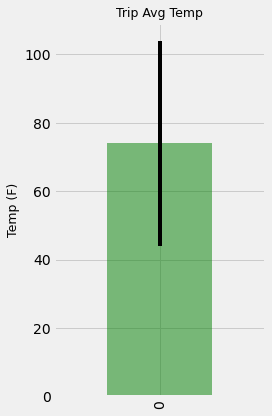

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tavg_temp = data_df['tavg']
tmin_tmax_temp = data_df.iloc[0]['tmax'] - data_df.iloc[0]['tmin']
tavg_temp.plot(kind='bar', yerr=tmin_tmax_temp, figsize=(4,6), alpha=0.5, color='g')
plt.title("Trip Avg Temp", fontsize=12.5)
plt.ylabel("Temp (F)", fontsize=12.5)
plt.tight_layout()
plt.show()

In [102]:
# Calculating the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.

trip_startdate = '2015-01-01'
trip_enddate = '2016-12-31'

data = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
       filter(Measurement.station == Station.station).filter(Measurement.date >= trip_startdate).\
       filter(Measurement.date<=trip_enddate).group_by(Station.name).order_by(func.sum(Measurement.prcp)).all()
data

[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [87]:
# Calculating the averages for tmin, tmax, and tavg for all historic data matching a specific month and day

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [113]:
# calculating the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Setting the start and end date of the trip

# Using the start and end date to create a range of dates

# Stripping off the year and save a list of strings in the format %m-%d
 
# Using the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

# Using the start and end date to create a range of dates

# Stipping off the year and save a list of %m-%d strings



start_date = '2017-08-01'
end_date = '2017-08-07'

results=session.query(Measurement.date).order_by(Measurement.date.asc()).\
       filter(Measurement.date>=start_date).\
       filter(Measurement.date<=end_date).distinct()


tripdate_df=pd.DataFrame(results.all())
normal=tripdate_df['date'].str.slice(start=5)
tripdate_df = tripdate_df.set_index('date')


daily_norms=[]
for month_date in range(len(normal)):
    daily_value=daily_normals(normal[month_date])[0]
    daily_norms.append(tuple(daily_value))

In [116]:
# Loading the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index 

data_df=pd.DataFrame(daily_norms)

tripdate_df['tmin']=data_df[0].tolist()
tripdate_df['tavg']=data_df[1].tolist()
tripdate_df['tmax']=data_df[2].tolist()
tripdate_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


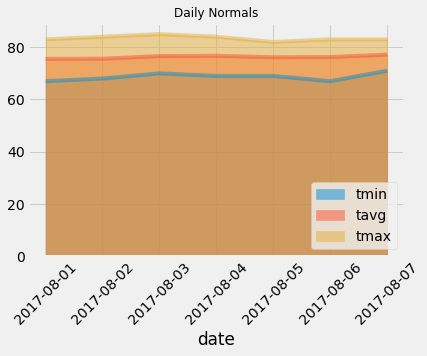

In [111]:
# Plotting the daily normals as an area plot with `stacked=False`
tripdate_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.title("Daily Normals", fontsize=12)
plt.legend(loc='lower right')
plt.show()

In [112]:
# Closing Session
session.close()